# Stock Prediction

This project introduces common techniques to manipulate time series and make predictions.

The data is a sample from the historical [NSE(National Stock Exchange) ](https://www.nseindia.com/products/content/equities/indices/historical_index_data.htm). Only the  NIFTY 50 will be considered for analysis. 

There roughly 365 days of recoreded trading for the mentioned index.

## Present data 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [15]:
DATAPATH = 'data/data1.csv'

In [16]:
data = pd.read_csv(DATAPATH)
data.head(10)

,Date,Open,High,Low,Close
0,05-Nov-2018,10558.75,10558.80,10477.00,10524.0
1,06-Nov-2018,10552.00,10600.25,10491.45,10530.0
2,07-Nov-2018,10614.45,10616.45,10582.30,10598.4
3,09-Nov-2018,10614.70,10619.55,10544.85,10585.2
4,12-Nov-2018,10607.80,10645.50,10464.05,10482.2
5,13-Nov-2018,10451.90,10596.25,10440.55,10582.5
6,14-Nov-2018,10634.90,10651.60,10532.70,10576.3
7,15-Nov-2018,10580.60,10646.50,10557.50,10616.7
8,16-Nov-2018,10644.00,10695.15,10631.15,10682.2
9,19-Nov-2018,10731.25,10774.70,10688.80,10763.4


In [17]:
data.shape

(244, 5)

In [18]:
data.dtypes

Date      object
Open     float64
High     float64
Low      float64
Close    float64
dtype: object

In [19]:
data.head()

,Date,Open,High,Low,Close
0,05-Nov-2018,10558.75,10558.80,10477.00,10524.0
1,06-Nov-2018,10552.00,10600.25,10491.45,10530.0
2,07-Nov-2018,10614.45,10616.45,10582.30,10598.4
3,09-Nov-2018,10614.70,10619.55,10544.85,10585.2
4,12-Nov-2018,10607.80,10645.50,10464.05,10482.2


## Exploratory data analysis (EDA)

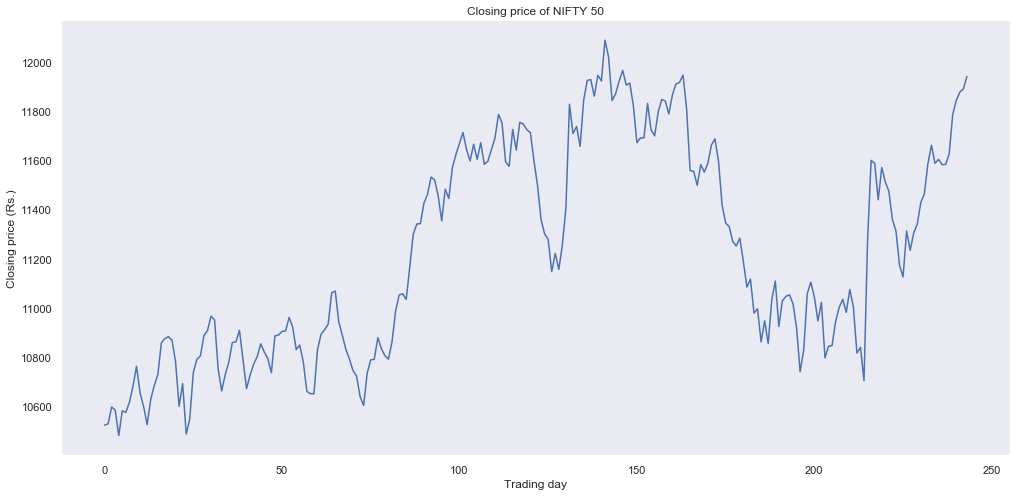

In [21]:
plt.figure(figsize=(17, 8))
plt.plot(data.Close)
plt.title('Closing price of NIFTY 50')
plt.ylabel('Closing price (Rs.)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

### Moving average

In [48]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

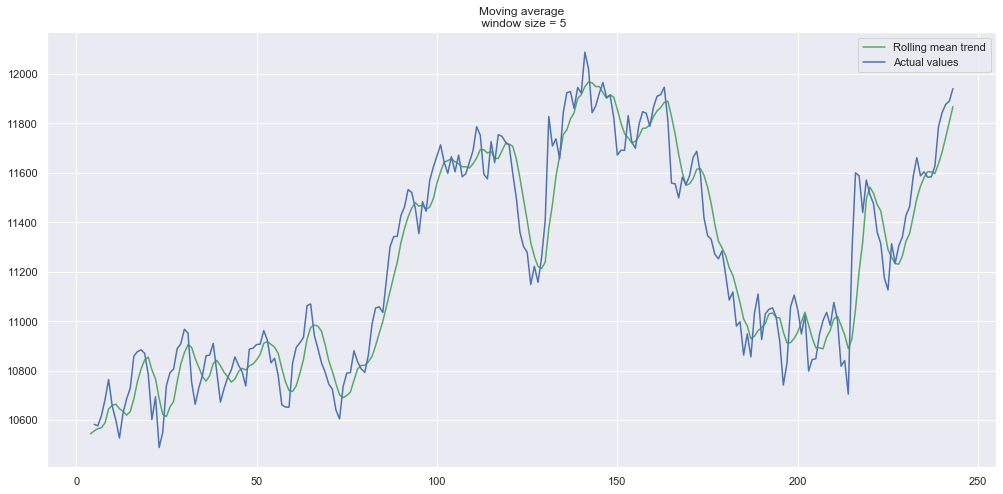

In [49]:
#Smooth by the previous 5 days (by week)
plot_moving_average(data.Close, 5)
#plot_moving_average(data.Close, 5,plot_intervals=True)

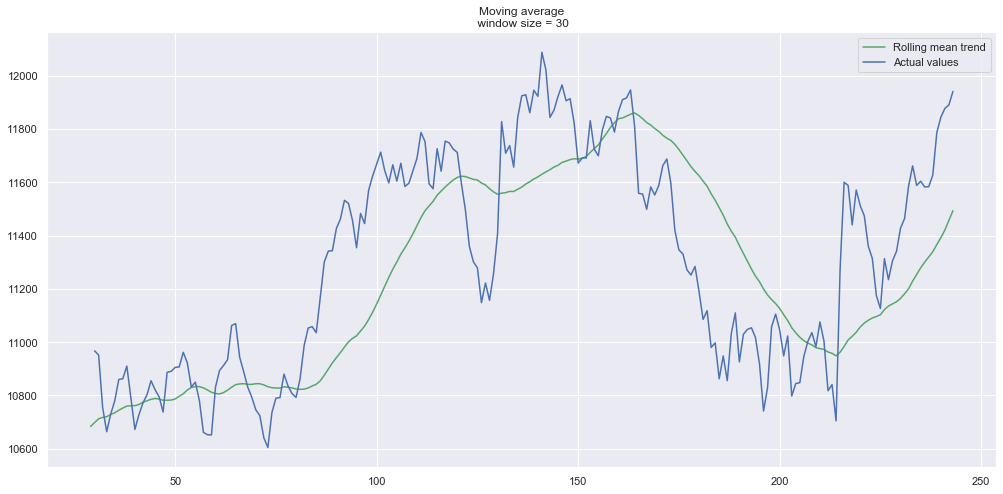

In [35]:
#Smooth by the previous month (30 days)
plot_moving_average(data.Close, 30)

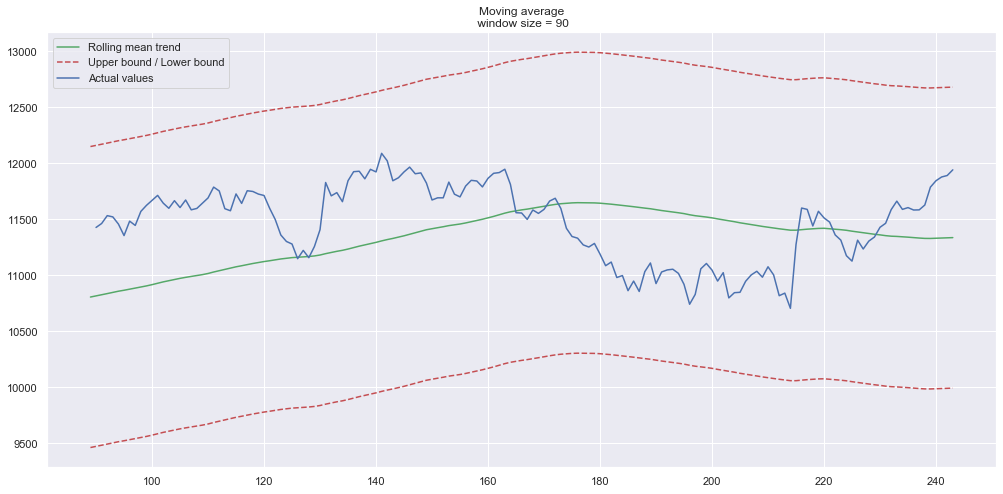

In [50]:
#Smooth by previous quarter (90 days)
plot_moving_average(data.Close, 90, plot_intervals=True)

### Exponential smoothing

In [65]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [73]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
  
    plt.title("Exponential Smoothing")
    plt.grid(True);

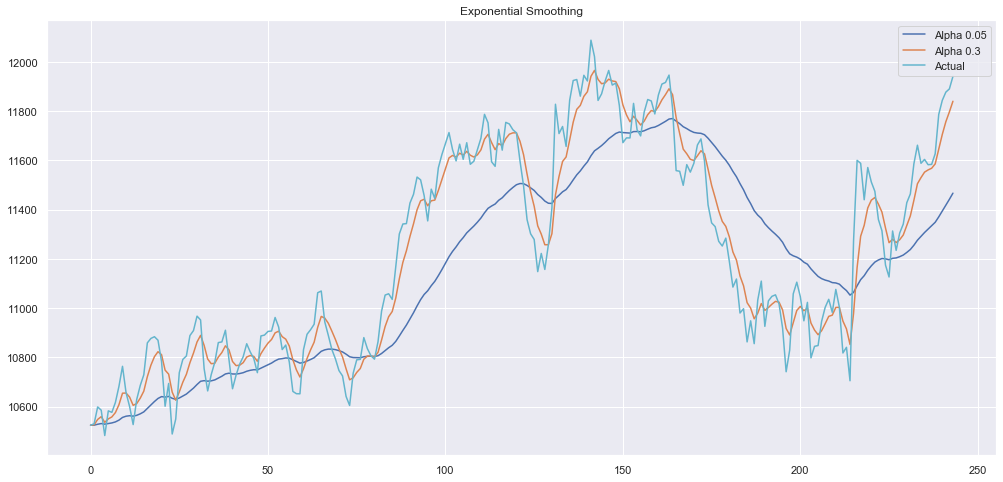

In [74]:
plot_exponential_smoothing(data.Close, [0.05,0.3])

### Double exponential smoothing 

In [62]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [63]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")

    plt.title("Double Exponential Smoothing")
    plt.grid(True)

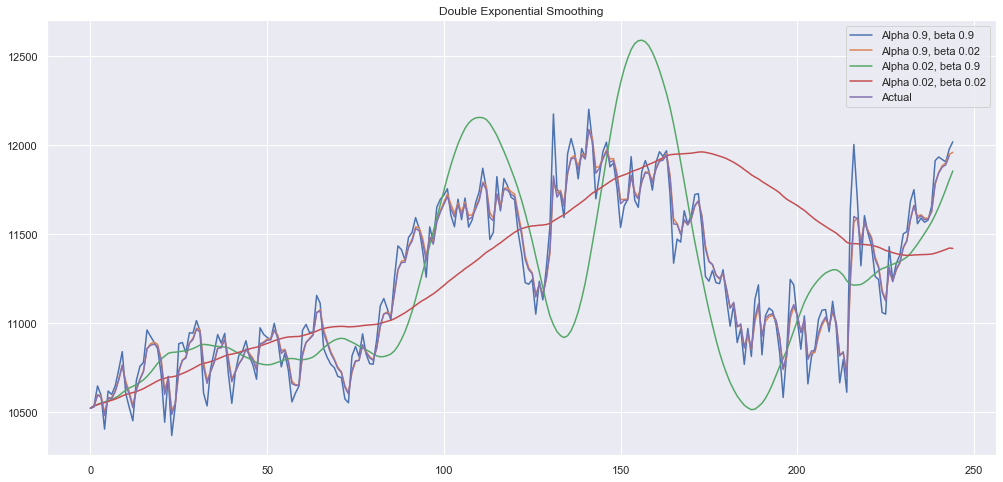

In [64]:
plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Stationarity 

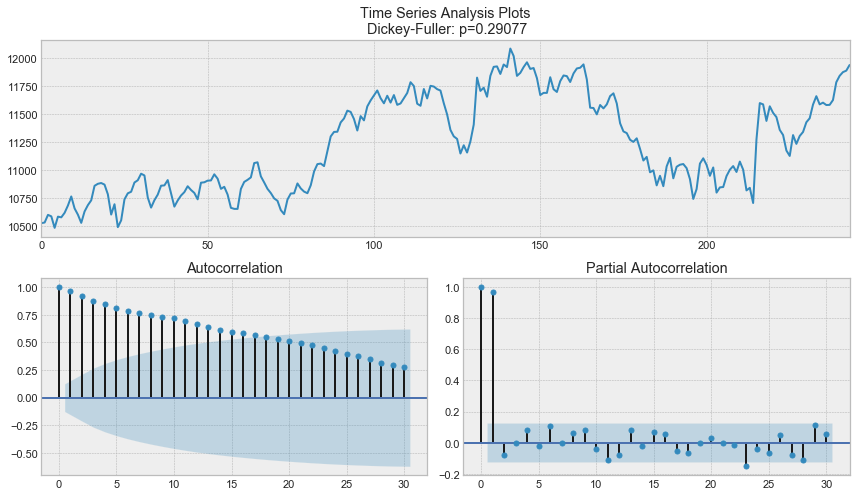

In [76]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.Close, lags=30)

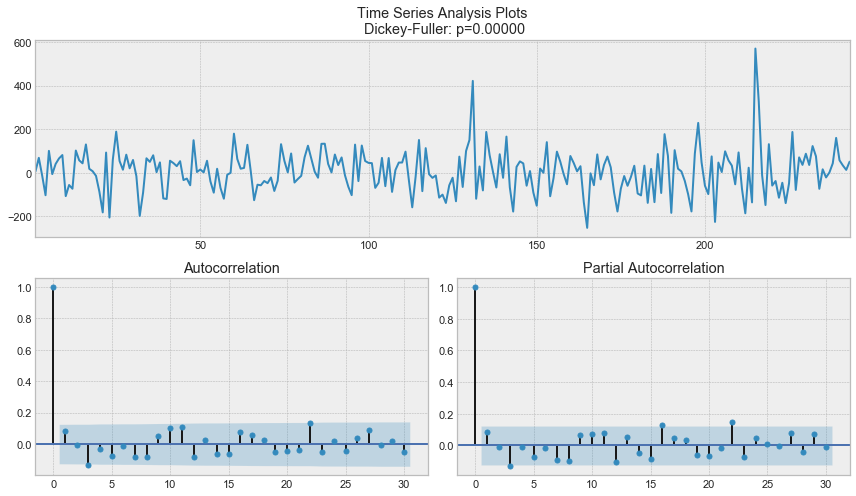

In [77]:
data_diff = data.Close - data.Close.shift(1)

tsplot(data_diff[1:], lags=30)

## SARIMA

In [35]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [36]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.Close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

In [37]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.Close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

#print(best_model.summary())

In [43]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'Close': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 5)
print(best_model.predict(start=data.Close.shape[0], end=data.Close.shape[0] + 5))
print(mean_absolute_percentage_error(data.Close[s+d:], best_model.fittedvalues[s+d:]))

244    11981.011373
245    11933.329863
246    11989.180994
247    11929.248177
248    11957.076176
249    11961.132913
dtype: float64
0.6870138374373748


In [47]:
comparison = pd.DataFrame({'actual': [11890.60, 11941.30, 11917.20, 11860.45],
                          'predicted': [11981.011373,11933.329863, 11989.180994, 11929.248177]}, 
                          index = pd.date_range(start='2019-11-05', periods=4,))

In [48]:
comparison.head()

,actual,predicted
2019-11-05,11890.60,11981.011373
2019-11-06,11941.30,11933.329863
2019-11-07,11917.20,11989.180994
2019-11-08,11860.45,11929.248177


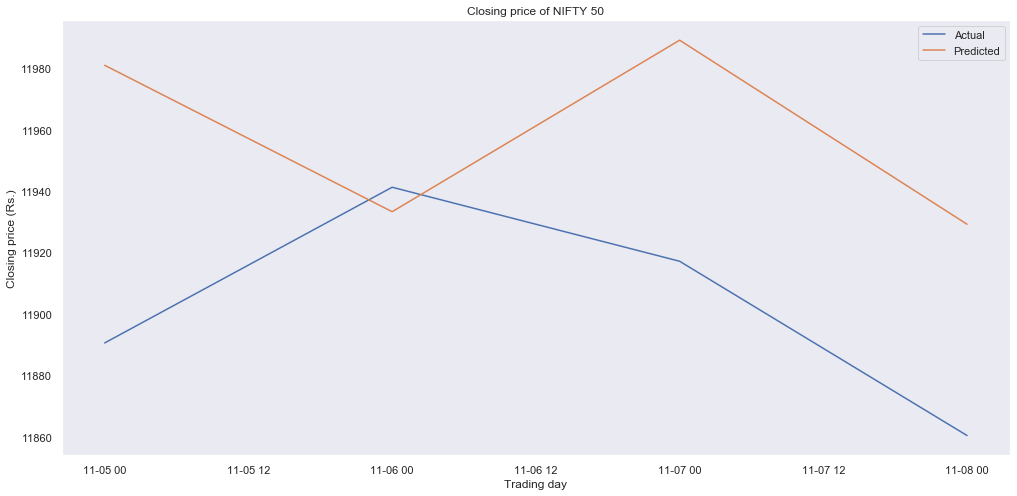

In [51]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.actual, label="Actual")
plt.plot(comparison.predicted, label="Predicted")
plt.title('Closing price of NIFTY 50')
plt.ylabel('Closing price (Rs.)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()